In [1]:
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt, Tsit5
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import jax
import numpy as np

import jax.random as jrandom

import time
from functools import partial
from pcuq_utils import *

cd = jnp.array([-0.4, 0.02])
c, d = 0.4, 0.02
def transform(args):
    args = jax.nn.sigmoid(args)
    return jnp.stack([args.at[1].multiply(-1), cd], 0)

def lvfunc(t, y, args):
    u, v = y
    a, b = jax.nn.sigmoid(args)
    du = a * u - b * u * v
    dv = -c * v + d * u * v
    nugget = 1e-6
    return jnp.array([du, dv]) + nugget

true_param_vals = jnp.array([-2, -4]) + 0.0
x_init = jnp.ones((2,)) * 10.0

tmax = 90.0
tobs = 60.0

ts = jnp.linspace(0.0, tobs, 100)

term = ODETerm(lvfunc)
solver = Dopri5()
saveat = SaveAt(ts=ts)

solution = diffeqsolve(term, solver, t0=0, t1=tmax, dt0=0.1, y0=x_init, saveat=SaveAt(dense=True), args=true_param_vals)

In [2]:
from diffrax import ControlTerm, Euler, MultiTerm, VirtualBrownianTree, ReversibleHeun
key = jrandom.PRNGKey(30) # 15
rng, key = jrandom.split(key)

diff_coef = jnp.array([0.0, 0.4])
diffusion = lambda t, y, args: diff_coef

brownian_motion = VirtualBrownianTree(t0=0, t1=tmax, tol=1e-5, shape=(2,), key=rng)
terms = MultiTerm(ODETerm(lvfunc), ControlTerm(diffusion, brownian_motion))
solver = ReversibleHeun() #Euler()
saveat = SaveAt(dense=True)

sol = diffeqsolve(terms, solver, t0=0, t1=tmax, dt0=0.05, y0=x_init, saveat=saveat, args=true_param_vals)

In [3]:
specified = False
solfunc = solution.evaluate if specified else sol.evaluate

noise_sigma = 1.0
ts = jnp.linspace(0, tobs, 60)[1:]
obs = jax.vmap(solfunc)(ts)

obs_1 = jax.vmap(solution.evaluate)(ts)
obs_2 = jax.vmap(sol.evaluate)(ts)

rng, key = jrandom.split(key)
obs += noise_sigma * jrandom.normal(rng, obs.shape)
rng, key = jrandom.split(key)
obs_1 += noise_sigma * jrandom.normal(rng, obs.shape)

In [4]:
def build_lotka_volterra(y0, ts, params):
    def lvfunc(t, y, args):
        u, v = y
        a, b = jax.nn.sigmoid(args) # transform
        du = a * u - b * u * v
        dv = -c * v + d * u * v
        nugget = 1e-10
        return jnp.array([du, dv]) + nugget
        
    term = ODETerm(lvfunc)
    solver = Tsit5()
    saveat = SaveAt(ts=ts)
    return diffeqsolve(term, solver, t0=ts[0], t1=ts[-1], dt0=0.05, y0=x_init, saveat=saveat, args=params).ys

In [31]:
def main(bayes_init, mmd_init, func_dict, key, reg_const, n_particles=10):
    n_iters = 5000
    ss = 1e-6
    
    params_init = jnp.stack([bayes_init] * n_particles, 0)
    func = func_dict['bayes']
    rng, key = jrandom.split(key)
    params_init += 1e-6 * jrandom.normal(rng, params_init.shape)
    
    rng, key = jrandom.split(key)
    tr_bayes = mala(func, n_iters, ss, params_init, 1., rng, multi=True)

    params_init2 = tr_bayes[-1]#jnp.stack([mmd_init] * n_particles, 0)
    func = func_dict['mmd-bayes']
    rng, key = jrandom.split(key)
    tr_mmd = mala(func, n_iters, ss, params_init2, reg_const, rng, multi=True)

    func = func_dict['pcuq']
    params_init3 = tr_mmd[-1]

    #func2 = func_dict['pcuq-mh']
    rng, key = jrandom.split(key)
    tr_pcuq1 = mala(func, n_iters, ss, params_init3, reg_const, rng, multi=False)
    #tr_pcuq1 = mala_pcuq(func, func2, n_iters, ss, params_init2, reg_const, rng)

    rng, key = jrandom.split(key)
    tr_pcuq2 = mala(func, n_iters, ss, params_init3, reg_const*0.1, rng, multi=False)
    #tr_pcuq2 = mala_pcuq(func, func2, n_iters, ss, params_init2, reg_const*0.1, rng)

    rng, key = jrandom.split(key)
    tr_pcuq3 = mala(func, n_iters, ss, params_init3, reg_const*10, rng, multi=False)
    #tr_pcuq3 = mala_pcuq(func, func2, n_iters, ss, params_init2, reg_const*10, rng)
    return tr_bayes, tr_mmd, tr_pcuq1, tr_pcuq2, tr_pcuq3

In [32]:
func_dict = build_func_dict(obs, ts, 0.1, x_init, noise_sigma, build_lotka_volterra, product=True)
key = jrandom.PRNGKey(124)

rng, key = jrandom.split(key)
traces = main(true_param_vals, true_param_vals, func_dict, rng, 1e-3)

func_dict = build_func_dict(obs_1, ts, 0.1, x_init, noise_sigma, build_lotka_volterra, product=True)
rng, key = jrandom.split(key)
traces_ws = main(true_param_vals, true_param_vals, func_dict, rng, 1e-3)

1000: 0.5300000309944153
2000: 0.49000000953674316
3000: 0.5300000309944153
4000: 0.5699999928474426
5000: 0.5800000429153442
1000: 0.7000000476837158
2000: 0.7099999785423279
3000: 0.6399999856948853
4000: 0.6000000238418579
5000: 0.6800000071525574
1000: 0.5
2000: 0.20000000298023224
3000: 0.800000011920929
4000: 0.5
5000: 0.800000011920929
1000: 0.20000000298023224
2000: 0.699999988079071
3000: 0.4000000059604645
4000: 0.30000001192092896
5000: 0.4000000059604645
1000: 0.800000011920929
2000: 0.6000000238418579
3000: 0.4000000059604645
4000: 0.5
5000: 0.30000001192092896
1000: 0.7900000214576721
2000: 0.6600000262260437
3000: 0.6700000166893005
4000: 0.6899999976158142
5000: 0.6200000643730164
1000: 0.5300000309944153
2000: 0.6200000047683716
3000: 0.5600000023841858
4000: 0.6100000143051147
5000: 0.5700000524520874
1000: 0.699999988079071
2000: 0.20000000298023224
3000: 0.4000000059604645
4000: 0.9000000357627869
5000: 0.699999988079071
1000: 0.0
2000: 0.4000000059604645
3000: 0.5


### Make figure 1

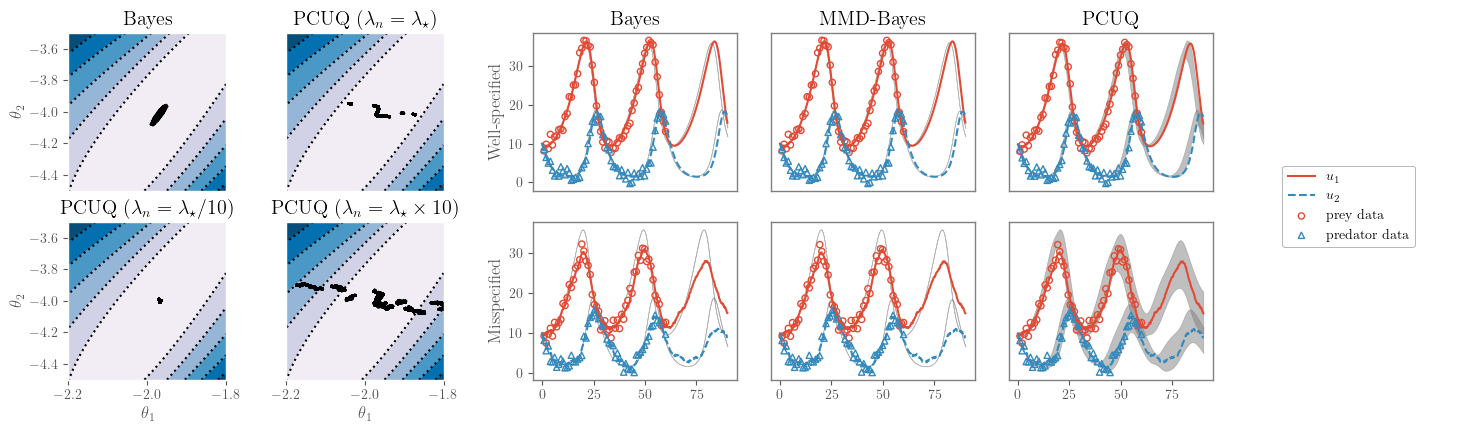

In [28]:
from matplotlib.gridspec import GridSpec
plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'sans-serif'
})
from matplotlib import rc
rc('font',**{'family':'serif'})

import matplotlib as mpl
#mpl.use('Agg')

fig = plt.figure(figsize=(18, 4.5))
gs = GridSpec(4, 7, figure=fig, hspace=0.5, wspace=0.2, width_ratios=[0.9, 0.9, 0.04, 1, 1, 1, 1,])

xmin = -2.2
xmax = -1.8
ymin = -4.5
ymax = -3.5
n_grid = 100

xs = jnp.linspace(xmin, xmax, n_grid)
ys = jnp.linspace(ymin, ymax, n_grid)
p0 = jnp.meshgrid(xs, ys)
ps = jnp.stack(p0, -1).reshape((-1, 2))
t0 = jnp.linspace(0.0, tmax, 500)
func_dict = build_func_dict(obs_1, ts, noise_sigma, x_init, noise_sigma, build_lotka_volterra, product=True)
logls = jax.vmap(func_dict['bayes'], 0)(ps) - 0.5 * jnp.sum(jnp.square(ps), -1)
levels = jnp.linspace(jnp.min(logls), jnp.max(logls), 7)

ax1 = fig.add_subplot(gs[0:2, 0])
ax1.set_xticks([])
ax1.set_ylabel(r'$\theta_2$')

ax2 = fig.add_subplot(gs[2:4, 0])
ax2.set_xlabel(r'$\theta_1$')
ax2.set_ylabel(r'$\theta_2$')

ax3 = fig.add_subplot(gs[0:2, 1])
ax3.set_xticks([])
ax3.set_yticks([])

ax4 = fig.add_subplot(gs[2:4, 1])
ax4.set_yticks([])
ax4.set_xlabel(r'$\theta_1$')

from matplotlib import cm

def contourplot(axis):
    cs = axis.contourf(p0[0], p0[1], logls.reshape((n_grid, n_grid)), levels=levels, cmap=cm.PuBu_r)
    axis.contour(cs, colors='k', linestyles='dotted')
    return axis

titles = ['Bayes', 'PCUQ (' + r'$\lambda_n=\lambda_{\star}$' + ')', 'PCUQ (' + r'$\lambda_n=\lambda_{\star}/10$' + ')', 'PCUQ (' + r'$\lambda_n=\lambda_{\star}\times 10$' + ')']
for ax, tr, tl in zip([ax1, ax3, ax2, ax4], [traces_ws[0], traces_ws[2], traces_ws[3], traces_ws[4]], titles):
    contourplot(ax)
    ax.set_aspect(abs(xmax-xmin)/abs(ymax-ymin))
    points = jnp.array(tr[-2000:]).reshape((-1, 2))
    ax.scatter(points[:, 0], points[:, 1], marker='o', edgecolor='black', facecolors='none', s=2)
    ax.set_title(tl)
    ax.grid(False)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

def plot_ci(axis, obs, params, solfunc):
    trajs = jax.vmap(build_lotka_volterra, (None, None, 0))(x_init, t0, params)
    t1 = jnp.sort(trajs, 0)
    ms = jnp.mean(t1, 0)
    stds = jnp.std(t1, 0)
    quart = 0.67448

    #smin = t1[3, :, :]
    #smax = t1[-4, :, :]
    #ms = jnp.mean(t1[3:-3, :, :], 0)
    
    tr = jax.vmap(solfunc)(t0)     
    #axis.fill_between(t0, smin[:, 0], smax[:, 0], color='gray', alpha=.5)
    #axis.fill_between(t0, smin[:, 1], smax[:, 1], color='gray', alpha=.5)

    axis.fill_between(t0, ms[:, 0] - quart * stds[:, 0], ms[:, 0] + quart * stds[:, 0], color='gray', alpha=.5)
    axis.fill_between(t0, ms[:, 1] - quart * stds[:, 1], ms[:, 1] + quart * stds[:, 1], color='gray', alpha=.5)
    
    line1, = axis.plot(t0, tr[:, 0], c='C0', label=r'$u_1$')
    points1 = axis.scatter(ts, obs[:, 0], marker='o', edgecolor='C0', s=20, facecolors='none', label='prey data', linewidth=1)
    
    line2, = axis.plot(t0, tr[:, 1], c='C1', linestyle='dashed', label=r'$u_2$')
    points2 = axis.scatter(ts, obs[:, 1], marker='^', edgecolor='C1', s=20, facecolors='none', label='predator data', linewidth=1)
    return axis, [line1, line2, points1, points2]

def process_ax(ax):
    ax.grid(False)
    ax.set_facecolor('w')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')


titles = ['Bayes', 'MMD-Bayes', 'PCUQ']

ax4 = fig.add_subplot(gs[0:2, 3])
ax4.set_ylabel('Well-specified')
ax4.set_yticks([0, 10, 20, 30])
ax4.set_xticks([])
ax8 = fig.add_subplot(gs[0:2, 4])
ax8.set_xticks([])
ax8.set_yticks([])

ax9 = fig.add_subplot(gs[0:2, 5])
ax9.set_xticks([])
ax9.set_yticks([])
for ax, tr, tl in zip([ax4, ax8, ax9], [traces_ws[0], traces_ws[1], traces_ws[2]], titles):
    ax, handles = plot_ci(ax, obs_1, tr[-1], solution.evaluate)
    ax.set_title(tl)
    process_ax(ax)

ax5 = fig.add_subplot(gs[2:4, 3])
ax5.set_ylabel('Misspecified')
ax5.set_yticks([0, 10, 20, 30])

ax6 = fig.add_subplot(gs[2:4, 4])
ax6.set_yticks([])
ax7 = fig.add_subplot(gs[2:4, 5])
ax7.set_yticks([])

for ax, tr in zip([ax5, ax6, ax7], [traces[0], traces[1], traces[2]]):
    ax, handles = plot_ci(ax, obs, tr[-1], sol.evaluate)
    process_ax(ax)

leg = fig.add_subplot(gs[1:3, 6])
lg = leg.legend(handles=handles, loc='center')
leg.set_xticks([])
leg.set_yticks([])
leg.set_facecolor('w')
frame = lg.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('0.5')

plt.savefig('f1.pdf', bbox_inches='tight')

### Make figure 2

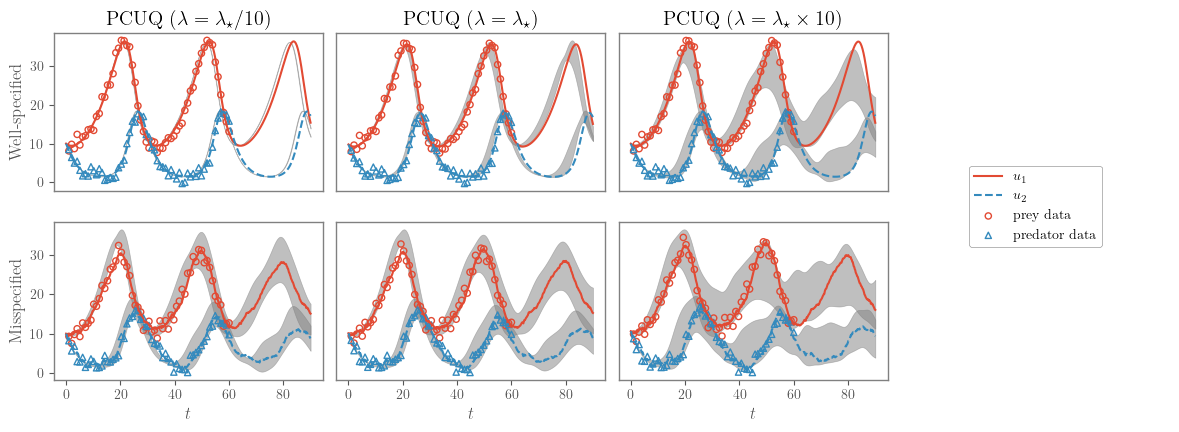

In [11]:
fig = plt.figure(figsize=(14.4, 4.5))
gs = GridSpec(4, 4, figure=fig, hspace=0.5, wspace=0.05, height_ratios=[1, 1, 1, 1])

ax_ws = [gs[0:2, 0], gs[0:2, 1], gs[0:2, 2]]
ax_ws = [fig.add_subplot(g) for g in ax_ws]

ax_ms = [gs[2:4, 0], gs[2:4, 1], gs[2:4, 2]]
ax_ms = [fig.add_subplot(g) for g in ax_ms]

titles = ['PCUQ (' + r'$\lambda=\lambda_{\star}/10$' + ')', 'PCUQ (' + r'$\lambda=\lambda_{\star}$' + ')', 'PCUQ (' + r'$\lambda=\lambda_{\star}\times 10$' + ')']

for ax, tr, tl in zip(ax_ws, [traces_ws[3], traces_ws[2], traces_ws[4]], titles):
    ax, handles = plot_ci(ax, obs_1, tr[-1], solution.evaluate)
    ax.set_title(tl)
    ax.set_xticks([])
    process_ax(ax)

for ax, tr in zip(ax_ms, [traces[3], traces[2], traces[4]]):
    ax, handles = plot_ci(ax, obs, tr[-1], sol.evaluate)
    process_ax(ax)
    ax.set_xlabel(r'$t$')

for ax in ax_ws[1:]:
    ax.set_yticks([])
for ax in ax_ms[1:]:
    ax.set_yticks([])

ax_ws[0].set_ylabel('Well-specified')
ax_ms[0].set_ylabel('Misspecified')

leg = fig.add_subplot(gs[1:3, 3])
lg = leg.legend(handles=handles, loc='center')
leg.set_xticks([])
leg.set_yticks([])
leg.set_facecolor('w')
frame = lg.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('0.5')

plt.savefig('f2.pdf', bbox_inches='tight')

### Make figure 3

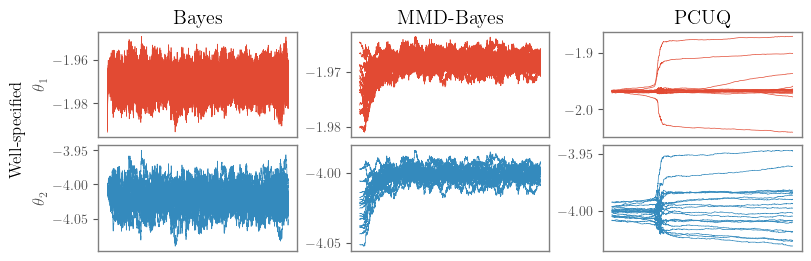

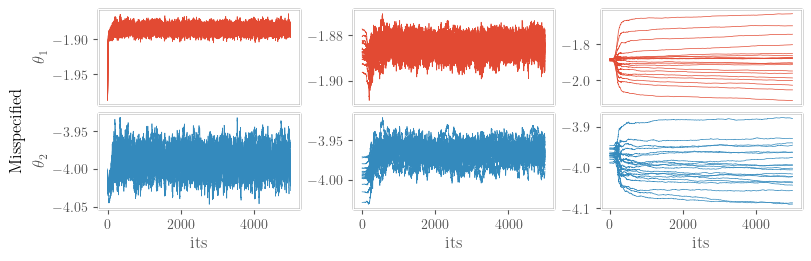

In [29]:
colors = ['C0', 'C1']
fig, axs = plt.subplots(2, 3, figsize=(8, 2.5), constrained_layout=True)#, sharex=True)
for i in range(2):
    for j, tr, titles in zip(list(range(3)), [traces_ws[0], traces_ws[1], traces_ws[2]], ['Bayes', 'MMD-Bayes', 'PCUQ']):
        tr0 = jnp.array(tr)
        for k in range(tr0.shape[1]):
            axs[i, j].plot(tr0[:, k, i], c=colors[i], linewidth=0.5)
        axs[i, j].set_xlabel('')
        axs[i, j].set_xticks([])
        if i == 0:
            axs[i, j].set_title(titles)
        process_ax(axs[i, j])

axs[0, 0].set_ylabel(r'$\theta_1$')
axs[1, 0].set_ylabel(r'$\theta_2$')
fig.supylabel('Well-specified')
plt.savefig('ws_traces1.pdf', bbox_inches='tight')

fig, axs = plt.subplots(2, 3, figsize=(8, 2.5), constrained_layout=True)#, sharex=True)
for i in range(2):
    for j, tr in zip(list(range(3)), [traces[0], traces[1], traces[2]]):
        tr0 = jnp.array(tr)
        for k in range(tr0.shape[1]):
            axs[i, j].plot(tr0[:, k, i], c=colors[i], linewidth=0.5)
        if i == 1:
            axs[i, j].set_xlabel('its')
        axs[i, j].grid(False)
        axs[i, j].set_facecolor('w')
        axs[i, j].patch.set_edgecolor('black')  
        axs[i, j].patch.set_linewidth(1)

axs[0, 0].set_xticks([])
axs[0, 1].set_xticks([])
axs[0, 2].set_xticks([])
axs[0, 0].set_ylabel(r'$\theta_1$')
axs[1, 0].set_ylabel(r'$\theta_2$')
fig.supylabel('Misspecified')
plt.savefig('ms_traces1.pdf', bbox_inches='tight')

In [16]:
def main_particles(mmd_init, func_dict, key, reg_const, n_parts):
    n_iters = 5000
    ss = 1e-4

    traces = []
    for n_particles in n_parts:
        rng, key = jrandom.split(key)
        params_init = jnp.stack([mmd_init] * n_particles, 0)
        params_init += 1e-6 * jrandom.normal(rng, params_init.shape)
        func = func_dict['pcuq']
        trs = mala(func, n_iters, ss, params_init, reg_const, rng, multi=False)
        traces.append(trs)
    return traces

n_parts = [5, 10, 15]

func_dict = build_func_dict(obs_1, ts, 0.1, x_init, noise_sigma, build_lotka_volterra, product=True)
key = jrandom.PRNGKey(124)
traces_parts = main_particles(true_param_vals, func_dict, key, 1e-3, n_parts)

1000: 0.4000000059604645
2000: 0.4000000059604645
3000: 0.20000000298023224
4000: 0.5
5000: 0.10000000149011612
1000: 0.5
2000: 0.699999988079071
3000: 0.6000000238418579
4000: 0.4000000059604645
5000: 0.5
1000: 0.20000000298023224
2000: 0.30000001192092896
3000: 0.4000000059604645
4000: 0.4000000059604645
5000: 0.4000000059604645


### Make figure 4

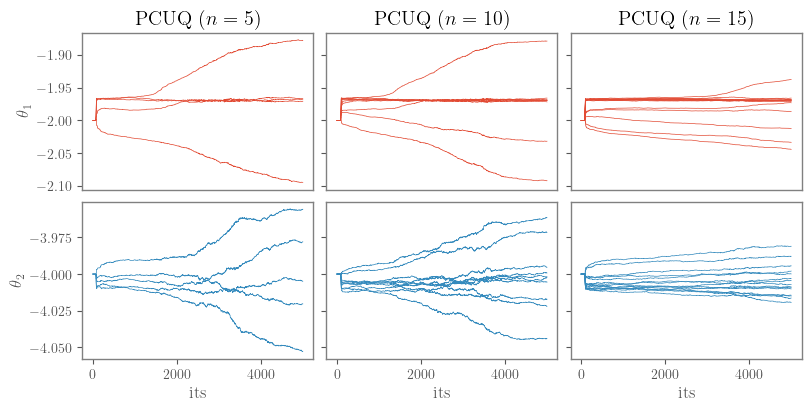

In [17]:
colors = ['C0', 'C1']
fig, axs = plt.subplots(2, len(n_parts), figsize=(8, 4), constrained_layout=True, sharey='row')#, sharex=True)
for i, n_particles in enumerate(n_parts):
    tr0 = jnp.array(traces_parts[i])
    axs[0, i].set_xticks([])
    axs[0, i].set_xlabel('')
    axs[1, i].set_xlabel('its')
    axs[0, i].set_title('PCUQ (' + r'$n={}$'.format(n_particles) + ')')
    for k in range(tr0.shape[1]):
        axs[0, i].plot(tr0[:, k, 0], c=colors[0], linewidth=0.5)
        axs[1, i].plot(tr0[:, k, 1], c=colors[1], linewidth=0.5)
    process_ax(axs[0, i])
    process_ax(axs[1, i])
    
axs[0, 0].set_ylabel(r'$\theta_1$')
axs[1, 0].set_ylabel(r'$\theta_2$')
plt.savefig('f4_ws.pdf', bbox_inches='tight')